In [146]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from datetime import datetime
from matplotlib.ticker import MaxNLocator
import matplotlib.cbook as cbook
import matplotlib.dates as mdates

Data Retreival

In [147]:

# Connect to Google
# Scope: Enable access to specific links
scope = ['https://www.googleapis.com/auth/spreadsheets', "https://www.googleapis.com/auth/drive"]

credentials = ServiceAccountCredentials.from_json_keyfile_name("./gscredentials.json", scope)

client = gspread.authorize(credentials)

# Open the Google Sheet
sheet_id = '1CxCLvg2CGSHYNWskSa8JlBOPmF4th4XPEQQfy6AouYw'

sheet = client.open_by_key(sheet_id)

worksheet = sheet.get_worksheet(0)  # Assuming you want to work with the first worksheet

data = worksheet.get_all_values()

#names = [row[0] for row in data[1:]]  # Assuming first row contains headers


Data Structures

In [150]:
class TreeNode:
    def __init__(self, data):
            self.data = data
            self.children = []
            self.parent = None
    def add_child(self, child):
          child.parent = self
          self.children.append(child)
    def print_tree(self):
        print(self.data)
        if len(self.children) > 0:
            for child in self.children:
                child.print_tree()
    def get_level(self):
        if self.parent == 0:
            return level
        level+=1
        self.get_level(self.parent)
def build_tree():
      root = TreeNode("users")

      steve = TreeNode("steve")

      root.add_child(steve)

      return root


if __name__ == '__main__':
    root = build_tree()
    pass

steve_data = [row for row in data[1:] if row[10] == "sdimov77@gmail.com" or "Steven Dimov"]

rows_body_weight = [row for row in steve_data if row[8] != '']  

Plotting

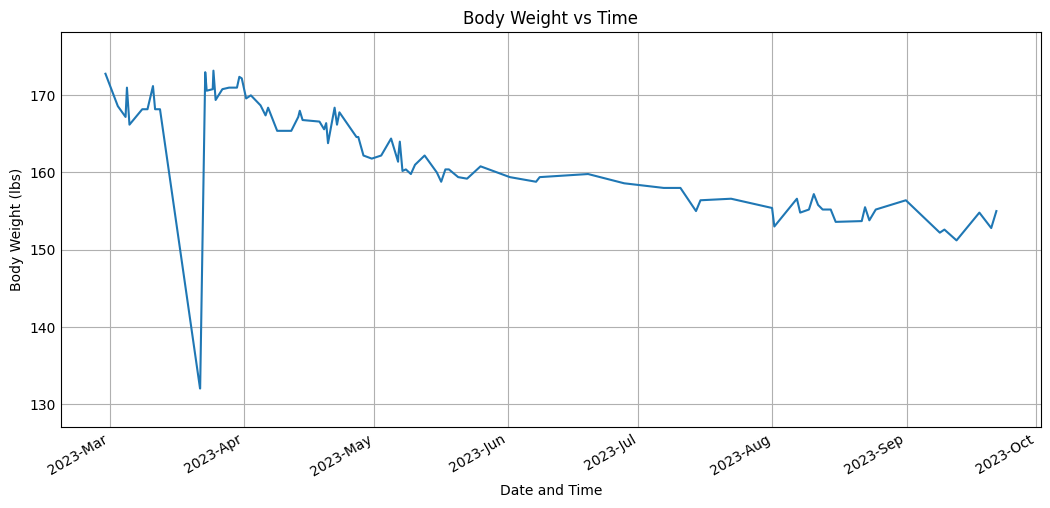

In [151]:

dates = [datetime.strptime(row[0], '%m/%d/%Y %H:%M:%S') for row in rows_body_weight]

weights = [float(row[8]) for row in rows_body_weight]

body_weights = [(datetime.strptime(row[0], '%m/%d/%Y %H:%M:%S'),float(row[8])) for row in rows_body_weight]


body_weights

# Assuming you have lists 'dates' and 'values'
#sorted_data = sorted(zip(dates, body_weights))
#dates, body_weights = zip(*sorted_data)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 5))
# Set locator for x-axis
#ax.xaxis.set_major_locator(MaxNLocator(nbins=12))
# Set locator for y-axis
#ax.yaxis.set_major_locator(MaxNLocator(nbins=10))
#ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
#ax.xaxis.set_minor_locator(mdates.MonthLocator())
# Text in the x-axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

plt.ylim(min(weights)-5, max(weights)+5)
#plt.yticks([25,50,75,100,125,150,175,200,225,250])

plt.plot(dates, weights)

# Set labels and title
plt.xlabel('Date and Time')
plt.ylabel('Body Weight (lbs)')
plt.title('Body Weight vs Time')

# Format x-axis date
plt.gcf().autofmt_xdate()  # Rotate date labels for better visibility

# Show the plot
#plt.show()

In [152]:
sheet_id = '1CxCLvg2CGSHYNWskSa8JlBOPmF4th4XPEQQfy6AouYw'
xls = pd.ExcelFile(f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=xlsx")

tab1 = pd.read_excel(xls, 'data', header = 1)

tab1

,2023-02-26 20:10:24.513000,Bench,straight,barbell,1,155,8,7,Unnamed: 8,Unnamed: 9,Steven Dimov,Unnamed: 11,155.1,6,1240,9670,44983
0,2023-02-26 20:12:48.526,Bench,straight,barbell,2.0,155,8.0,8.0,NaN,NaN,Steven Dimov,NaN,155,4.0,1240.0,9670.0,44983
1,2023-02-26 20:15:59.527,Bench,straight,barbell,3.0,155,8.0,9.0,NaN,NaN,Steven Dimov,NaN,155,6.0,1240.0,9670.0,44983
2,2023-02-26 20:19:36.136,Bench,straight,barbell,4.0,155,8.0,8.0,NaN,NaN,Steven Dimov,NaN,155,51.0,1240.0,9670.0,44983
3,2023-02-26 20:22:57.518,tricep pull,single arm,cable,1.0,25,3.0,8.0,NaN,NaN,Steven Dimov,NaN,NaN,NaN,75.0,9670.0,44983
4,2023-02-26 20:24:43.467,tricep pull,single arm,cable,2.0,20,6.0,7.0,NaN,NaN,Steven Dimov,NaN,NaN,NaN,120.0,9670.0,44983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,#VALUE!
737,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,#VALUE!
738,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,#VALUE!
739,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,#VALUE!
